In [24]:
import os
import numpy as np
from gensim.models import Word2Vec
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

# ディレクトリの設定
save_dir = "../embeddings"
seasons = range(1, 22)

# 基準となるシーズンを設定（例: シーズン1）
base_season = 1

# シーズンごとの埋め込みモデルを読み込む
def load_embedding(season):
    embedding_file = os.path.join(save_dir, f"s{season}_single_ranked_teams_embedding")
    model = Word2Vec.load(embedding_file)
    return model.wv

# 基準シーズンの埋め込みを取得
base_embedding = load_embedding(base_season)

# 他のシーズンの埋め込みを基準に合わせて整合させる関数
def align_embeddings(base_embedding, target_embedding):
    # 共通の単語（ポケモン名）を取得
    common_vocab = list(set(base_embedding.index_to_key) & set(target_embedding.index_to_key))

    # 共通語彙のベクトルを取得
    base_vectors = np.array([base_embedding[word] for word in common_vocab])
    target_vectors = np.array([target_embedding[word] for word in common_vocab])

    # プロクルステス変換で整合
    R, _ = orthogonal_procrustes(target_vectors, base_vectors)
    aligned_vectors = np.dot(target_embedding.vectors, R)

    # aligned_vectors を KeyedVectors に戻す
    aligned_kv = KeyedVectors(vector_size=base_embedding.vector_size)
    aligned_kv.add_vectors(target_embedding.index_to_key, aligned_vectors)

    return aligned_kv

# シーズンごとの整合済み埋め込みを保存
aligned_embeddings = {base_season: base_embedding}

for season in seasons:
    if season != base_season:
        target_embedding = load_embedding(season)
        aligned_embedding = align_embeddings(base_embedding, target_embedding)
        aligned_embeddings[season] = aligned_embedding


カイリュー shift from 1 to 2: 0.05143002048134804
カイリュー shift from 2 to 3: 0.029409168288111687
カイリュー shift from 3 to 4: 0.037165794521570206
カイリュー shift from 4 to 5: 0.041206877678632736
カイリュー shift from 5 to 6: 0.036329399794340134
カイリュー shift from 6 to 7: 0.03575509786605835
カイリュー shift from 7 to 8: 0.033837512135505676
カイリュー shift from 8 to 9: 0.040062617510557175
カイリュー shift from 9 to 10: 0.04470396041870117
カイリュー shift from 10 to 11: 0.032672543078660965
カイリュー shift from 11 to 12: 0.03338025510311127
カイリュー shift from 12 to 13: 0.034402649849653244
カイリュー shift from 13 to 14: 0.04719071090221405
カイリュー shift from 14 to 15: 0.05569019168615341
カイリュー shift from 15 to 16: 0.026723729446530342
カイリュー shift from 16 to 17: 0.026212288066744804
カイリュー shift from 17 to 18: 0.0287019032984972
カイリュー shift from 18 to 19: 0.031806740909814835
カイリュー shift from 19 to 20: 0.0324651338160038
カイリュー shift from 20 to 21: 0.027905061841011047


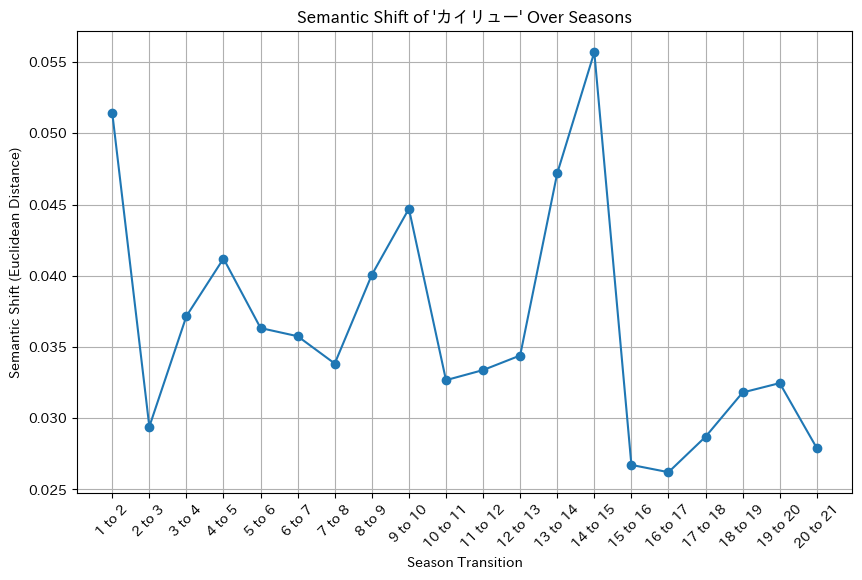

In [25]:
from numpy.linalg import norm
import japanize_matplotlib

# 特定の単語（ポケモン）の意味変化を計算する関数
def calculate_semantic_shift(word, aligned_embeddings, seasons):
    shifts = {}
    for i in range(len(seasons) - 1):
        season1 = seasons[i]
        season2 = seasons[i + 1]
        
        if word in aligned_embeddings[season1] and word in aligned_embeddings[season2]:
            embedding1 = aligned_embeddings[season1][word]
            embedding2 = aligned_embeddings[season2][word]
            
            # ベクトルのユークリッド距離を計算
            shift = norm(embedding2 - embedding1)
            shifts[f"{season1} to {season2}"] = shift
            
    return shifts

# 例: "カイリュー" の意味変化を計算
word = "カイリュー"
shifts = calculate_semantic_shift(word, aligned_embeddings, list(seasons))

# 結果を表示
for period, shift in shifts.items():
    print(f"{word} shift from {period}: {shift}")

# 時系列の変化をプロット
def plot_semantic_shift(word, shifts):
    periods = list(shifts.keys())
    values = list(shifts.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(periods, values, marker='o')
    plt.title(f"Semantic Shift of '{word}' Over Seasons")
    plt.xlabel("Season Transition")
    plt.ylabel("Semantic Shift (Euclidean Distance)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# "カイリュー" の変化を可視化
plot_semantic_shift(word, shifts)


In [26]:
from collections import defaultdict
from tqdm.auto import tqdm

# 全ポケモンの意味変化量を計算する関数
def calculate_all_semantic_shifts(aligned_embeddings, seasons):
    total_shifts = defaultdict(float)
    
    # 埋め込みに含まれる全ての単語を取得
    all_words = set()
    for embedding in tqdm(aligned_embeddings.values()):
        all_words.update(list(embedding.key_to_index.keys()))
    
    # 各ポケモンに対して意味変化を計算
    for word in all_words:
        for i in range(len(seasons) - 1):
            season1 = seasons[i]
            season2 = seasons[i + 1]
            
            if word in aligned_embeddings[season1] and word in aligned_embeddings[season2]:
                embedding1 = aligned_embeddings[season1][word]
                embedding2 = aligned_embeddings[season2][word]
                
                # ベクトルのユークリッド距離を計算し、累積
                shift = norm(embedding2 - embedding1)
                total_shifts[word] += shift
    
    return total_shifts

# 全ポケモンの意味変化量を計算
total_shifts = calculate_all_semantic_shifts(aligned_embeddings, list(seasons))

# 意味変化量が大きい順にソートして表示
sorted_shifts = sorted(total_shifts.items(), key=lambda x: x[1], reverse=True)

# 結果を表示
print("Most significant semantic shifts in Pokémon:")
for word, shift in sorted_shifts[:10]:  # 上位10件を表示
    print(f"{word}: Total Shift = {shift}")


  0%|          | 0/21 [00:00<?, ?it/s]

Most significant semantic shifts in Pokémon:
ハバタクカミ: Total Shift = 1.5807932242751122
ゴチルゼル: Total Shift = 1.5753796771168709
テツノツツミ: Total Shift = 1.5557576641440392
トドロクツキ: Total Shift = 1.5290201157331467
テツノカイナ: Total Shift = 1.5175441205501556
パオジアン: Total Shift = 1.3955381885170937
イーユイ: Total Shift = 1.3581871837377548
イダイナキバ: Total Shift = 1.3385832011699677
ディンルー: Total Shift = 1.334027111530304
チオンジェン: Total Shift = 1.3069468885660172
